# Calculating Confidence Interval with Bootstrapping

In this notebook, we are going to work with one of the datasets in [Kaggle](https://www.kaggle.com/majidarif17/weight-and-heightcsv). It is Weight-Height data sets. It contains height (in inches) and weight (in pounds) information seperated by gender <br>
We are going to use only height of people and compute a 95% confidence interval by using Bootstrap Method


## 1. First look
Let's start with importing necessary libraries with their common aliases

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

Load the dataset into a data frame and explore its characteristics

In [3]:
# Import the iris dataset
data = pd.read_csv('weight-height.csv')

# Looking at information
print("\nInfo:")
display(data.info())

# Summary Statistics
print("\nSummary Statistics:")
display(data.describe())

# Display first 5 rows
display(data.head())



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


None


Summary Statistics:


,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


## 2. Manipulate the data

Let's convert heights from inches to centimeters and add a new column into DataFrame

In [6]:
# Convert inches to centimeters
data["Height(cm)"] = data["Height"]*2.54

# Get summary statistics of Heights in centimeters
display(data['Height(cm)'].describe())

count    10000.000000
mean       168.573602
std          9.772721
min        137.828359
25%        161.304276
50%        168.447898
75%        175.702625
max        200.656806
Name: Height(cm), dtype: float64

As we can see, the maximum and minimum height in the data set are 137.8 cm and 200.6 cm respectively

Take 500 randomly selected heights

In [7]:
# Extract 500 random heights
heights = data['Height(cm)'].sample(500).reset_index(drop=True)

# Display Summary Statistics of women heights in cm
display(heights.describe())

count    500.000000
mean     168.889681
std       10.043576
min      137.828359
25%      161.088405
50%      168.541292
75%      175.911083
max      194.143779
Name: Height(cm), dtype: float64

## 3. Exploratory Data Analysis

If the data is distributed normally, what would happened ? To see this, let's plot the cumulative distribution function with mean and standard deviation of our empirical data.

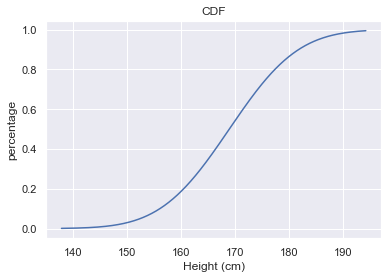

In [8]:
# Get Standard Deviation and Mean

heights_std = np.std(heights)
heights_mean = np.mean(heights)

# Plot Normal CDF
def plot_normal_CDF(data,mean,std,label,title):
    sns.set()
    # CDF of the data
    x = np.linspace(min(data),max(data),len(data))
    cdf = stats.norm.cdf(x,mean,std)
    
    plt.plot(x,cdf)
    plt.xlabel(label)
    plt.ylabel('percentage')
    plt.title(title)
    plt.show()
    return x,cdf

# CDF of Versicolor
x_cdf, y_cdf = plot_normal_CDF(heights, heights_mean, heights_std, "Height (cm)","CDF")


In addition to the CDF, plot the empirical cumulative distribution function and probability density function.

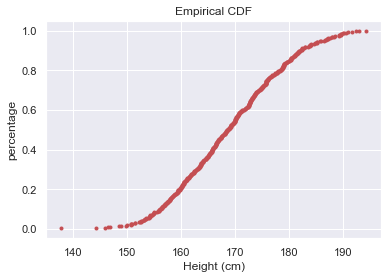

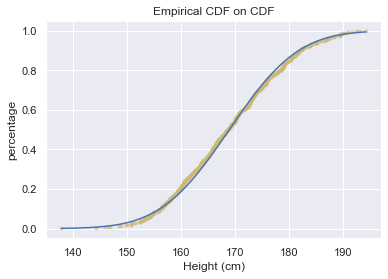

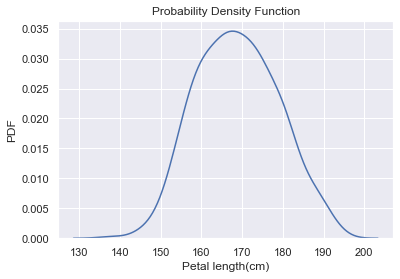

In [10]:
# Create a function to get x, y for of ecdf
def get_ecdf(data):
    
    # Get lenght of the data into n
    n = len(data)
    
    # We need to sort the data
    x = np.sort(data)
    
    # the function will show us cumulative percentages of corresponding data points
    y = np.arange(1,n+1)/n
    
    return x,y

# Create a function to plot ecdf
def plot_ecdf(data,labelx,labely,title,color):
    """Plot ecdf"""
    # Call get_ecdf function and assign the returning values
    x, y = get_ecdf(data)
    
    plt.plot(x,y,marker='.',linestyle='none',c=color)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title)

# Create a function overlay ECDF on CDF
def plot_overlay_ecdf(data,labelx,labely,title,color,x_cdf, y_cdf):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    x, y = get_ecdf(data)
    
    plt.plot(x,y,marker='.',linestyle='none',c=color,alpha=0.5)
    plt.plot(x_cdf, y_cdf)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title)
    
# Plotting Empirical CDF
plot_ecdf(heights,"Height (cm)","percentage","Empirical CDF","r")
plt.show()

# Overlap Empirical CDF on CDF
plot_overlay_ecdf(heights,"Height (cm)","percentage","Empirical CDF on CDF","y",x_cdf, y_cdf)
plt.show()

# Plotting PDF
sns.distplot(heights,hist=False)
plt.xlabel("Petal length(cm)")
plt.ylabel("PDF")
plt.title("Probability Density Function")
plt.show()


## 4. Bootstrapping

If we did the same experiment thousands of times, would we get the same mean ? <br>
To see this we are going to create bootstrap samples and replicates from them.

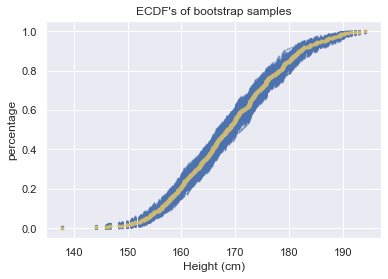

In [11]:

# Plot our original sample ecdf
plot_ecdf(heights,"Height (cm)","percentage","ECDF's of bootstrap samples","y")

for i in range(1000):
    
    # Generate a bootstrap sample
    bs_sample_heights = np.random.choice(heights,size=len(heights))
    
    # Plot ecdf for bootstrap sample
    x, y = get_ecdf(bs_sample_heights)
    plt.scatter(x, y,s=1,c='b',alpha=0.3)
    
plt.show()


We will need a function to generate bootstrap samples and draw bootstrap replicates from those samples as much as we want. Function will take three parameters data, func and size. 'func' parameter corresponds to the summary statistics that we will want to use when create a bootstrap replicate. 'size' parameter will demonstrate that how many replicates we need.

In [27]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates
        

Now we will use our function to get 10.000 bootstrap replicates. After that we will see how its PDF and ECDF look like.

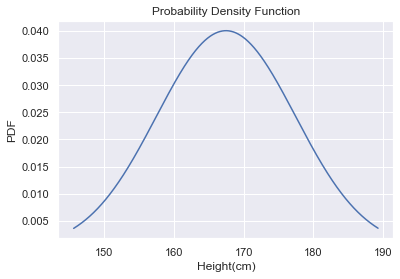

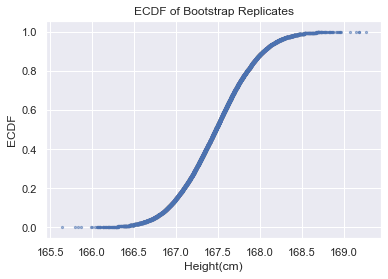

In [28]:
# Draw 10000 bootstrap replicates
bs_replicates_heights = draw_bs_replicates(heights,np.mean,15000)

# Plot probability density function
x = np.linspace(min(bs_replicates_heights)-20,max(bs_replicates_heights)+20,15000)
pdf = stats.norm.pdf(x, heights_mean, heights_std)
plt.plot(x,pdf)
plt.xlabel("Height(cm)")
plt.ylabel("PDF")
plt.title("Probability Density Function")
plt.show()

# Plot the ECDF of replicates
xsbs_ecdf, ysbs_ecdf = get_ecdf(bs_replicates_heights)
plt.scatter(xsbs_ecdf, ysbs_ecdf,s=5,c='b',alpha=0.5)
plt.xlabel("Height(cm)")
plt.ylabel("ECDF")
plt.title("ECDF of Bootstrap Replicates")
plt.show()


Let's compare the empirical mean and our replicates' mean

In [15]:
print("Empirical mean: " + str(heights_mean))

# Get the value of 50th percentile of bootstrap replicates
print("Bootstrap replicates mean: " + str(np.mean(bs_replicates_heights)))

Empirical mean: 168.65661881557742
Bootstrap replicates mean: 168.6535488982738


## 5. What is the confidence interval ?

We saw that the means are almost the same. <br>
Now its time to find the 95% confidence interval. 
It is quite simple and straightforward. We just need the area between 2.5th - 97.5th percentiles.

In [16]:
conf_interval = np.percentile(bs_replicates_heights,[2.5,97.5])

print("The confidence interval: ",conf_interval)

The confidence interval:  [167.77904671 169.51984003]


We found a confidence interval between 167.2cm to 162.5cm. We can say that if we choose someone randomly, her/his height will be between this interval with %95 chance. (Since our original sample is randomly selected, the values can be change each run)

## 6. Summary

Let's summarize what we did in this notebook,
* We resampled the our original sample and we got bootstrap samples
* We got the bootstrap replicates with mean from resampled data 10.000 times
* According to our bootstrap replicates we found a confidence interval with %95 confidence

I wish you goodluck in your data journey !